In [427]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import gammainc as gamma
from scipy.special import iv as I
from scipy.special import factorial
from scipy.signal import unit_impulse as delta
from scipy.stats import ncx2
marcumQ = ncx2.cdf
e = np.exp(1)

# first target: compute the probability distribution and look at it. Check that it is normalized.

In [428]:
kap = 0.01 # trapping
k1 = 0.1 # rest
k2 = 1.0 # motion
v = 1.0
    
def p(x,t,kap=kap,k1=k1,k2=k2,v=v,special=False):
    t = t.astype('float128')
    x = x.astype('float64')
    kp = k1+k2
    tmxv = t-x/v
    the = np.heaviside(tmxv,1)
    tmxv[tmxv<=0]=0.0
    a = e**(-(kap+k1)*tmxv-k2*x/v)
    b = 1/v*np.sqrt(k1*k2*x/v/tmxv)*the*I(1,2*np.sqrt(k1*k2*x/v*tmxv))
    c = k2/v*the*I(0,2*np.sqrt(k1*k2*x/v*tmxv))
    d = kap*k2/v/(kap+k1)*the*e**(-k2*x/v)

    def P1(x,y):
        # this is the sum over incomplete gamma functions
        # implemented from scratch
        n = 150 # number of terms to keep in the sum
        j = np.arange(n).reshape(-1,1).astype('float64')    
        Q = x**j/factorial(j)*gamma(j+1,y) # normalized version
        return np.nansum(Q,0)
    
    def P1py(x,y):
        # it can also be expressed as a marcum Q-function
        # which is equivalent to a non-central chi-squared cdf
        # this code block provides
        # e^{-x}*\sum_{n=0}^\infty \frac{x^n}{n!n!}\gamma(n+1,y)
        # notice gamma(n+1,y) as implemented here is the normalized version.
        # it includes a factor of n! already.
        from scipy.stats import ncx2
        Q = ncx2.cdf
        return Q(y*2,df=2,nc=2*x)        
    return a*(b+c)+d*e**(k1*k2*x/v/(kap+k1))*P1py( k1*k2*x/v/(kap+k1), (kap+k1)*tmxv)

    

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply


0.0
0.9962525984091285
0.9976305463514838
0.997720450649813
0.9977263140397282
0.0
0.9979166902343739
0.999825475057405
0.9999853855436469
0.9999987766896051


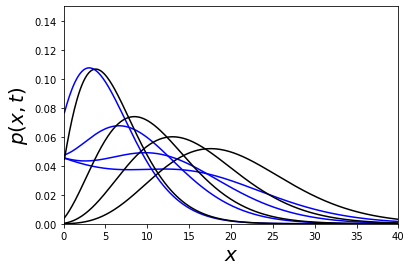

In [429]:
x = np.linspace(0,100,1000)
dx = x[1]-x[0]
t = np.linspace(0,100,5)
kap = 0.01 # trapping
k1 = 0.1 # rest
k2 = 1.0 # motion
v = 2.0
for tt in t:
    plt.plot(x,p(x,tt,kap=kap,k1=k1,k2=k2,v=v),color='blue')
    print(np.nansum(p(x,tt,kap=kap,k1=k1,k2=k2,v=v))*dx)
    
kap = 0.0 # trapping
k1 = 0.1 # rest
k2 = 1.0 # motion
v = 2.0
for tt in t:
    plt.plot(x,p(x,tt,kap=kap,k1=k1,k2=k2,v=v),color='black')
    print(np.nansum(p(x,tt,kap=kap,k1=k1,k2=k2,v=v))*dx)
    
plt.xlim(0,40)
plt.ylim(0,0.15)
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$p(x,t)$',fontsize=20)
#plt.title('Diffusion of probability',fontsize=20)
plt.savefig('trapping-pdf.png', bbox_inches='tight')


# Next task, look at the numerical variance and make sure it has three stages.

In [507]:
# compute p(x,t) over a grid
t = np.arange(0,1e2,1e-2)
x = np.arange(0,1e2,1e-2)
kap = 1/20.0 # trapping
k1 = 1/5.0 # rest
k2 = 1 # motion
v = 3
# calculate the variance
P = []
for tt in t:
    P.append(p(x,tt,kap=kap,k1=k1,k2=k2,v=v))

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply


In [510]:
# compute the variance
means = [np.nansum(x*p) for p in P]
var = [np.nansum((x*p-m)**2) for m,p in zip(means,P)]

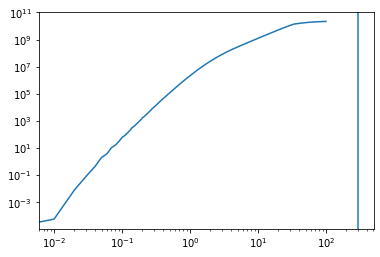

In [511]:
# look at it
plt.loglog(t,var)
plt.axvline(t.max()*v)
t0 = np.geomspace(0.5,10,10)
#plt.loglog(t0,t0**3*0.8e2,color='black') 
t1 = np.geomspace(8e-1,500,10)
#plt.loglog(t1,t1**2*4e2,color='black')


# now test that the mean matches its formula in the paper

In [574]:
def mean(t,kap,k1,k2,v):
    kp=k1+k2
    a = (kap + kp)/2
    b = np.sqrt(a**2-kap*k2)
    out = 1/b*e**(-a*t)*np.sinh(b*t)
    out += (kap+k1)/2/b*(1/(b-a)*(e**((b-a)*t)-1) + 1/(a+b)*(e**(-(a+b)*t)-1))
    return out

In [ ]:
t = np.arange(1e-3,1e6,1e-1)
kap = 0.01 # trapping
k1 = 0.2 # rest
k2 = 5 # motion
v = 1
#plt.plot(t,mean(t,kap,k1,k2,v))

plt.loglog(t,mean(t,kap,k1,k2,v))
plt.axvline(1/k1,label=r'$k_1$',color='red')
plt.axvline(1/k2,label=r'$k_2$',color='orange')
plt.axvline(1/kap,label=r'$\kappa$',color='blue')
a = (kap+k1+k2)/2
b = np.sqrt(a**2-kap*k2)
plt.legend(loc=1)
plt.xlim(1e-4,1e6)

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in sinh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply


(0.0001, 1000000.0)

# and test that the variance matches its formula in the paper

In [581]:
def var(t,kap,k1,k2,v):
    t = np.float128(t)
    kp=k1+k2
    a = (kap + kp)/2
    b = np.sqrt(a**2-kap*k2)
    out = t/b*np.sinh(b*t)
    out += (kap+k1)/b**3*(b*t*np.cosh(b*t)-np.sinh(b*t))
    out += e**(-a*t)*(b*(b**2*(a*t-2)-a**3*t)*np.cosh(b*t)+(a**3-a**2*b**2*t-3*a*b**2+b**4*t)*np.sinh(b*t))/(a-b)**2/(a+b)**2
    return out*2*v**2

In [570]:
var(t,kap,k1,k2,v)

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in sinh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in multiply
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in cosh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in multiply
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in sinh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in subtract
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in cosh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in multiply
/ho

array([-23122.58931693, -23122.58931056, -23122.58929907, ...,
                   nan,             nan,             nan], dtype=float128)

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in sinh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in multiply
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in cosh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in multiply
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in sinh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in subtract
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in cosh
/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in multiply
/ho

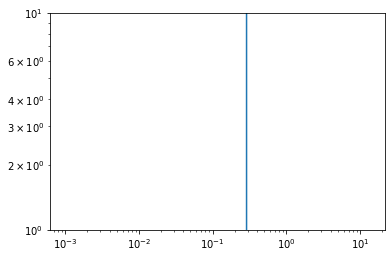

In [571]:

plt.loglog(t,var(t,kap,k1,k2,v))